In [2]:
import requests

In [8]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

In [5]:
url = f"https://api.eia.gov/v2/natural-gas/pri/fut/data/?api_key=pPdr4eeD92VC9pdHRffs6YMo6VSUvVk5JWI0MpQV&frequency=daily&data[0]=value&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"


In [6]:
response = requests.get(url)
data = response.json()  # Converts the response to a JSON dictionary

# Check if the request was successful
if response.status_code == 200:
    print("Data retrieval successful")
else:
    print("Failed to retrieve data:", data.get('message', 'No error message provided'))

Data retrieval successful


In [7]:
# Extract relevant data points
data_points = data['response']['data']

# Create a DataFrame focusing on specific columns
df = pd.DataFrame(data_points, columns = ['period', 'value'])

# Convert 'period' to a datetime type for time series analysis
df['period'] = pd.to_datetime(df['period'])

# Optionally, convert 'value' to a numeric type for numerical analysis
df['value'] = pd.to_numeric(df['value'], errors='coerce')

df.rename(columns = {'period' : 'Date', 'value' : 'Natural_Gas_Price'}, inplace = True)

In [155]:
#data = pd.read_csv('C:/Users/oyeye/Downloads/RNGWHHDd.csv')
#data.columns = data.columns.str.strip()

In [156]:
data = df.dropna()

In [157]:
data.set_index('Date', inplace=True)
data = data.sort_index(ascending = True)

In [158]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag = 'AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

In [159]:
check_stationarity(data['Natural_Gas_Price'])

ADF Statistic: -1.899703368570293
p-value: 0.3322006683743218
Series is not stationary


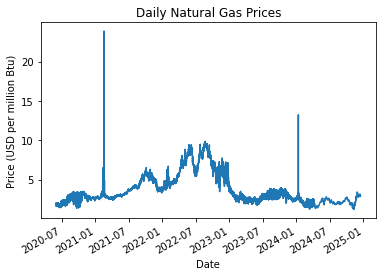

In [160]:
data['Natural_Gas_Price'].plot(title = 'Daily Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per million Btu)')
plt.show()

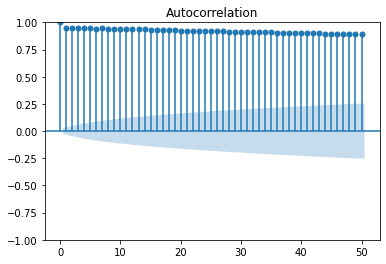

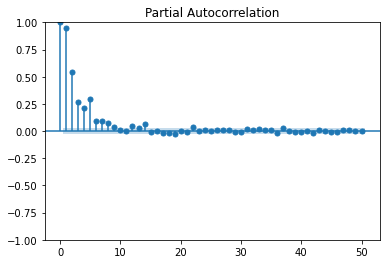

In [161]:
plot_acf(data['Natural_Gas_Price'].dropna(), lags = 50)
plot_pacf(data['Natural_Gas_Price'].dropna(), lags = 50)
plt.show()

In [164]:
# Auto ARIMA Model Selection
model_autoARIMA = auto_arima(data['Natural_Gas_Price'], start_p = 0, start_q = 0,
                             test = 'adf',       # use adftest to find optimal 'd'
                             max_p = 3, max_q = 3, # maximum p and q
                             m = 1,              # frequency of series
                             d = None,           # let model determine 'd'
                             seasonal = False,   # No Seasonality
                             start_P = 0, 
                             D = 0, 
                             trace = True,
                             error_action = 'ignore',  
                             suppress_warnings = True, 
                             stepwise = True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9841.956, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7977.753, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6897.904, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9839.956, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6855.661, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6850.890, Time=1.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7587.131, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6825.853, Time=1.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7344.021, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6810.995, Time=3.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6848.809, Time=1.74 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6785.093, Time=3.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6795.916, Time=3.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=6783.121, Time=2.24 sec
 ARIMA(2,1,3)(0,0,0)[0]          

In [165]:
# Fit ARIMA Model and Forecast
model = ARIMA(data['Natural_Gas_Price'], order = model_autoARIMA.order)
fitted_model = model.fit()

C:\Users\oyeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\oyeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\oyeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [166]:
# Forecast the next 30 days
fc = fitted_model.forecast(steps=30)
print(fc)

5000    2.975573
5001    2.941304
5002    2.991464
5003    2.984415
5004    2.963193
5005    2.962693
5006    2.975826
5007    2.977249
5008    2.969721
5009    2.968110
5010    2.972380
5011    2.973757
5012    2.971384
5013    2.970335
5014    2.971625
5015    2.972372
5016    2.971689
5017    2.971180
5018    2.971531
5019    2.971866
5020    2.971693
5021    2.971479
5022    2.971559
5023    2.971693
5024    2.971659
5025    2.971577
5026    2.971588
5027    2.971638
5028    2.971636
5029    2.971607
Name: predicted_mean, dtype: float64


C:\Users\oyeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\oyeye\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [167]:
print("Forecast values type:", type(fc))
print("Forecast values shape or size:", fc.shape if hasattr(fc, 'shape') else len(fc))
print("Dates type:", type(future_dates))
print("Dates shape or size:", future_dates.shape if hasattr(future_dates, 'shape') else len(future_dates))

Forecast values type: <class 'pandas.core.series.Series'>
Forecast values shape or size: (30,)
Dates type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Dates shape or size: (30,)


In [168]:
import pandas as pd

# Assuming the last date in your dataset is the index of the last observation
last_date = data.index[-1]

# Generate future dates starting the day after the last date in your historical data
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

In [176]:
# Convert date, price, and forecast data to 1D numpy arrays
date_array = np.array(data.index.to_pydatetime()).flatten()
price_array = np.array(data['Natural_Gas_Price']).astype(float).flatten()  # Convert and flatten
future_date_array = np.array(future_dates.to_pydatetime()).flatten()
fc_array = np.array(fc).flatten()  # Ensure the forecast data 'fc' is a flat numpy array

# Debugging print statements to check dimensions
print("Date array dimension:", date_array.ndim)
print("Price array dimension:", price_array.ndim)
print("Future date array dimension:", future_date_array.ndim)
print("Forecast array dimension:", fc_array.ndim)

Date array dimension: 1
Price array dimension: 1
Future date array dimension: 1
Forecast array dimension: 1


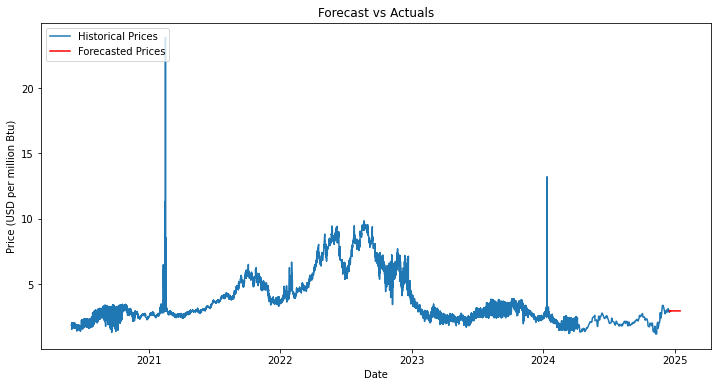

In [177]:
plt.figure(figsize=(12, 6))
plt.plot(date_array, price_array, label='Historical Prices')
if len(future_date_array) == len(fc_array):  # Ensure lengths match
    plt.plot(future_date_array, fc_array, label='Forecasted Prices', color='red')
else:
    print("Mismatch in length of future dates and forecast values.")
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Price (USD per million Btu)')
plt.legend(loc='upper left')
plt.show()

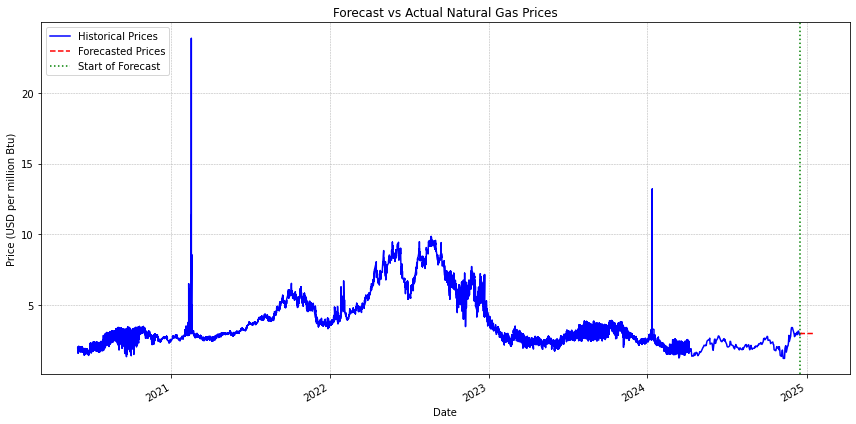

In [181]:
# Assuming date_array, price_array, future_date_array, and fc_array are already defined

plt.figure(figsize=(12, 6))

# Plotting historical data
plt.plot(date_array, price_array, label='Historical Prices', color='blue', linewidth=1.5)

# Plotting forecasted data
plt.plot(future_date_array, fc_array, label='Forecasted Prices', color='red', linestyle='--', linewidth=1.5)

# Adding titles and labels
plt.title('Forecast vs Actual Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per million Btu)')

# Formatting the date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotation

# Adding a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Highlighting specific points
# Assuming you want to highlight the start of the forecast
plt.axvline(x=future_date_array[0], color='green', linestyle=':', label='Start of Forecast')

# Adding a legend
plt.legend(loc='upper left')

# Using tight layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


MSE:  0.717613212070863


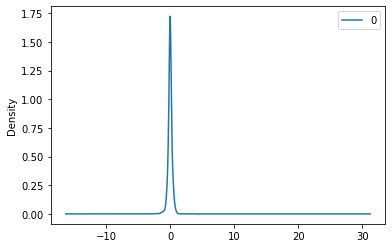

In [182]:
# Model Evaluation and Residual Check
mse = mean_squared_error(data['Natural_Gas_Price'].iloc[-30:], fc)
print('MSE: ', mse)

# Plots the density of the residuals to assess the distribution
residuals = pd.DataFrame(fitted_model.resid)
residuals.plot(kind = 'kde')
plt.show()

In [11]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Price': fc
})
print(forecast_df.to_csv(index=False))